In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from joblib import Parallel, delayed
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import itertools
import joblib
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score

In [39]:
#read csv
df = pd.read_csv("RFLFSODataFull.csv")
df.head()
df.describe()

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
count,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,9.137900e+04,91379.000000,91379.000000,91379.000000,...,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000,91379.000000
mean,6.769458,11.619098,9.553919,10.032760,9.076251,3297.930328,7.850005e+10,27.065979,28.417120,25.717089,...,13.166020,11.904558,11.373193,32986.417484,34636.684647,31331.618978,89.043304,0.739065,1.851020,0.702242
std,3.903843,3.438873,5.858577,6.162798,5.575927,1224.305893,5.000027e+09,72.134023,75.761896,68.595239,...,9.589755,8.694028,6.942229,24713.874445,25978.845228,23497.873065,26.415610,0.871314,1.762698,0.828796
min,0.788363,0.027142,1.141556,1.238270,1.049744,2012.000148,7.350000e+10,0.000000,0.000000,0.000000,...,-6.693373,-7.270075,0.000000,10.151990,11.029667,9.484346,0.000000,0.000000,0.000000,0.000000
25%,3.473063,10.829331,4.958993,5.205861,4.709511,2019.431812,7.350000e+10,0.000000,0.000000,0.000000,...,4.905387,4.438425,5.000000,11158.598400,11721.447545,10588.793240,82.976727,0.076749,0.512667,0.072912
50%,6.336167,11.856560,6.870737,7.205499,6.524046,2959.863686,8.350000e+10,0.000000,0.000000,0.000000,...,10.803943,9.774467,11.000000,26378.636210,27686.214030,25047.188460,90.867362,0.437995,1.323101,0.416274
75%,8.664984,12.847944,14.049470,14.782679,13.379256,4820.890157,8.350000e+10,16.947618,17.775980,16.038090,...,22.470382,20.322434,17.000000,53493.821285,56092.212375,50797.690405,98.482652,1.088621,2.681788,1.036574
max,32.455222,46.893150,24.790883,26.407305,24.268431,4827.999971,8.350000e+10,1621.001906,1753.747866,1500.666382,...,40.771383,36.724191,23.000000,75004.999150,82503.130080,74999.343410,360.000000,7.799086,16.421115,7.252319


In [40]:
#preprocessing
X=df.drop(columns=['FSO_Att','RFL_Att'])
y_FSO=df['FSO_Att']
y_RFL=df['RFL_Att']
X_train,X_test,y_FSO_train,y_FSO_test=train_test_split(
    X,y_FSO,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
X_train,X_test,y_RFL_train,y_RFL_test=train_test_split(
    X,y_RFL,train_size=0.8,test_size=0.2,random_state=1874845,stratify=df['SYNOPCode']
)
y_FSO_test.head()


68601    13.077835
68115     4.450609
28357     2.890493
17893     5.953451
60284     9.631533
Name: FSO_Att, dtype: float64

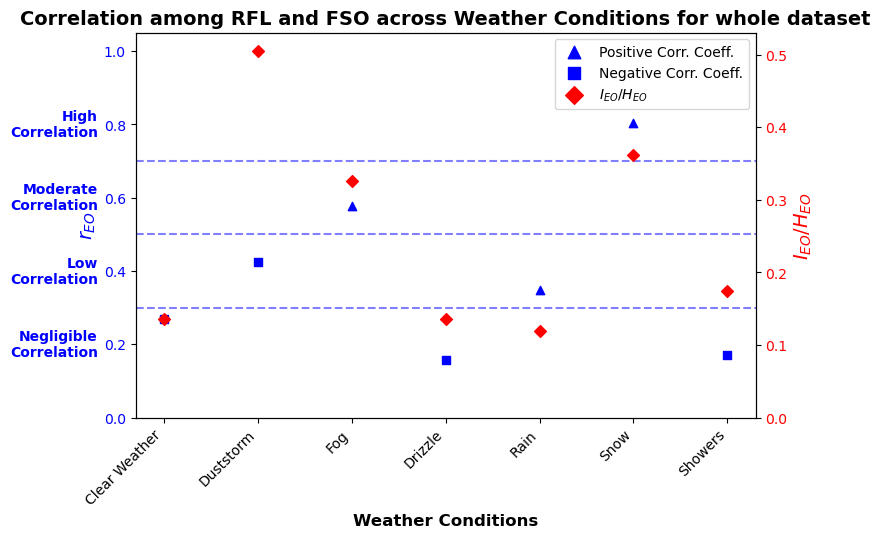

In [41]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = df[df['SYNOPCode'] == synop_code]
    rfl_pred = subset['RFL_Att']
    fso_pred = subset['FSO_Att']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.7, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.5, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.3, color='blue', linestyle='--', alpha=0.5, clip_on=True)

# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for whole dataset', fontsize=14, fontweight='bold')


plt.show()


In [42]:
#read csv
result = pd.read_csv("ProjectB_results.csv")
result.head()
result.describe()

,Unnamed: 0,SYNOPCode,y_pred_FSO_2,y_pred_RFL_2,FSO_pred_1,RFL_pred_1,y_FSO_test,y_RFL_test
count,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000,18276.000000
mean,45791.923233,2.213121,6.783085,11.625998,6.788885,11.633379,6.811413,11.645939
std,26350.544074,2.879741,3.783571,3.385933,3.752553,3.393459,3.965527,3.507115
min,0.000000,0.000000,0.880758,2.457932,0.983952,2.547737,0.848391,0.786776
25%,22963.000000,0.000000,3.497983,10.938156,3.516017,10.932628,3.457215,10.841029
50%,45576.000000,0.000000,6.469134,11.794253,6.488657,11.794627,6.371891,11.858661
75%,68574.500000,6.000000,8.650003,12.773473,8.662675,12.801684,8.676777,12.868948
max,91376.000000,8.000000,30.675284,45.546121,30.304111,46.089536,31.966746,46.853960


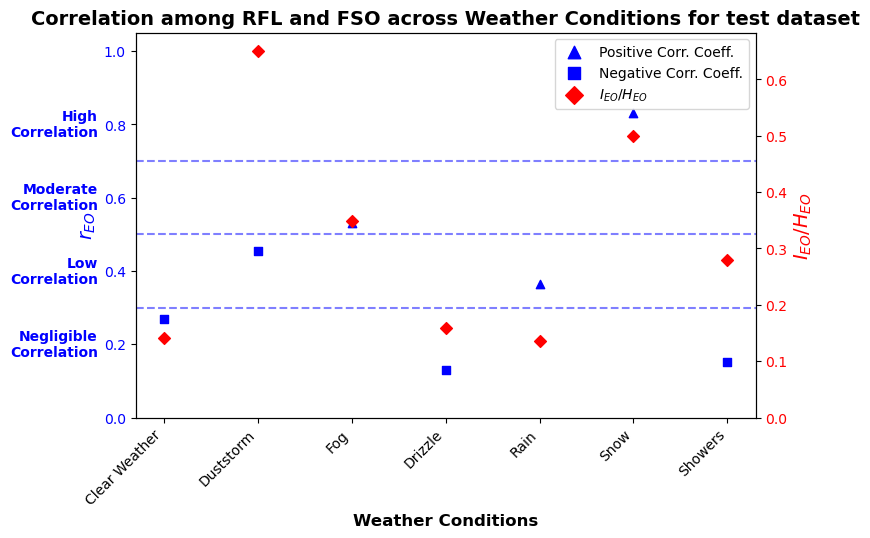

In [43]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = result[result['SYNOPCode'] == synop_code]
    rfl_pred = subset['y_RFL_test']
    fso_pred = subset['y_FSO_test']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.7, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.5, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.3, color='blue', linestyle='--', alpha=0.5, clip_on=True)

# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for test dataset', fontsize=14, fontweight='bold')


plt.show()

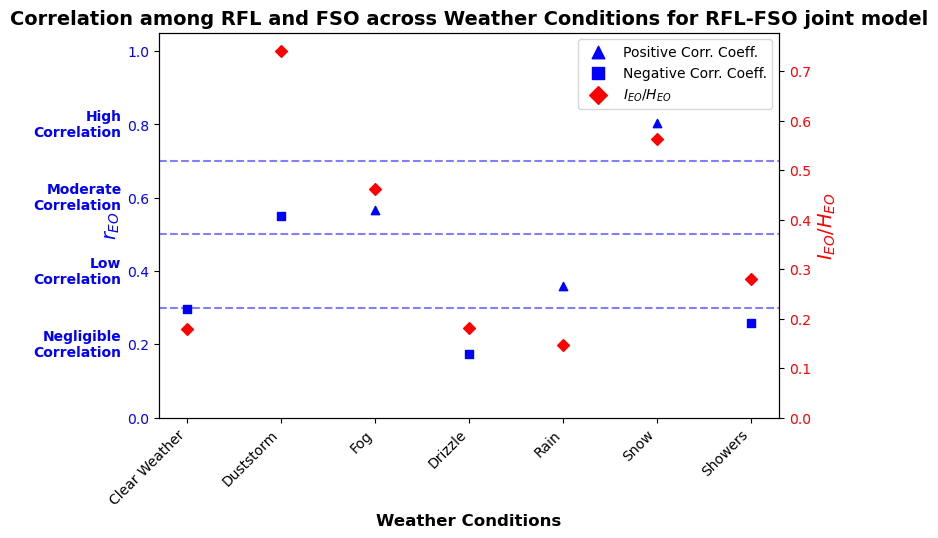

In [44]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = result[result['SYNOPCode'] == synop_code]
    rfl_pred = subset['RFL_pred_1']
    fso_pred = subset['y_pred_FSO_2']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.7, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.5, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.3, color='blue', linestyle='--', alpha=0.5, clip_on=True)

# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for RFL-FSO joint model', fontsize=14, fontweight='bold')


plt.show()

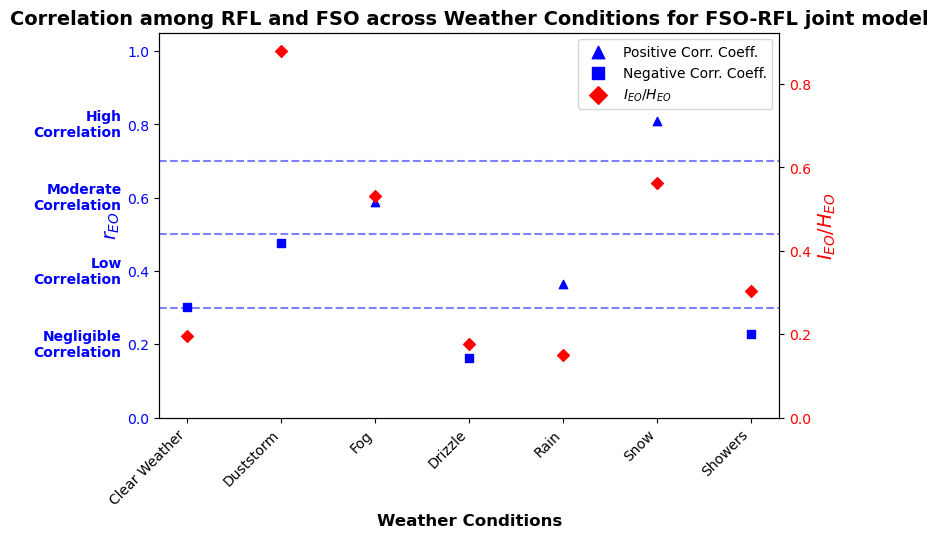

In [45]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = result[result['SYNOPCode'] == synop_code]
    rfl_pred = subset['y_pred_RFL_2']
    fso_pred = subset['FSO_pred_1']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.7, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.5, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.3, color='blue', linestyle='--', alpha=0.5, clip_on=True)


# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for FSO-RFL joint model', fontsize=14, fontweight='bold')


plt.show()

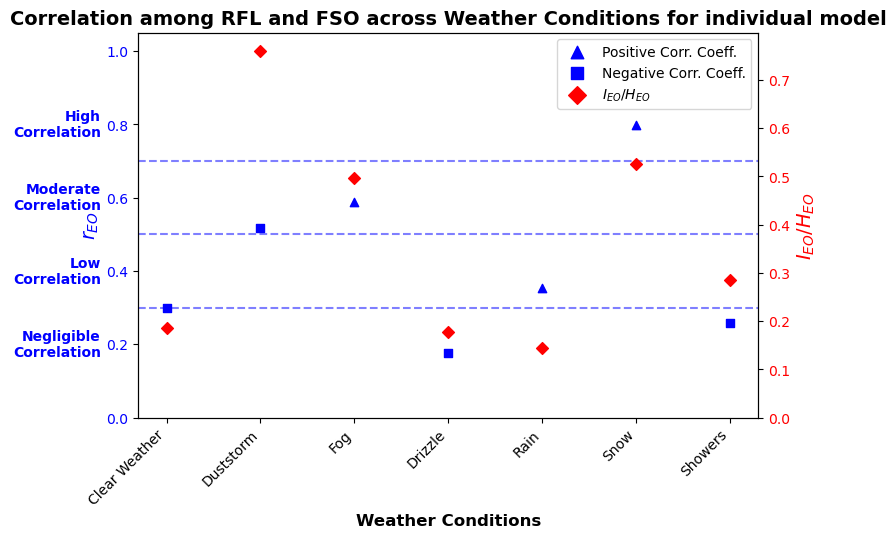

In [46]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear Weather",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes for X axis
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Prepare lists for plotting
positive_pearson = []
negative_pearson = []
mutual_info_ratios = []

# Calculate metrics and align them with ordered SYNOP codes
for synop_code in ordered_synop_codes:
    subset = result[result['SYNOPCode'] == synop_code]
    rfl_pred = subset['RFL_pred_1']
    fso_pred = subset['FSO_pred_1']
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    if pearson_corr >= 0:
        positive_pearson.append(pearson_corr)
        negative_pearson.append(np.nan)
    else:
        positive_pearson.append(np.nan)
        negative_pearson.append(-pearson_corr)
    # mutual info
    mutual_info = mutual_info_score(rfl_pred.round(), fso_pred.round())
    joint_entropy = mutual_info_score(rfl_pred.round(), rfl_pred.round())  
    mi_ratio = mutual_info / joint_entropy if joint_entropy > 0 else 0
    mutual_info_ratios.append(mi_ratio)

# plotting
fig, ax1 = plt.subplots(figsize=(8,5))

# Create an index for each SYNOP code in ordered_synop_codes to align data points with x-axis labels
x_positions = range(len(ordered_synop_codes))

# scatter plot for pearson
ax1.scatter(x_positions, positive_pearson, c='blue', marker='^', label='Positive Corr. Coeff.')
ax1.scatter(x_positions, negative_pearson, c='blue', marker='s', label='Negative Corr. Coeff.')
ax1.set_xlabel('Weather Conditions', fontsize=12, fontweight='bold')
ax1.set_ylabel(r'$r_{EO}$', color='blue', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, 1.05)

# Set custom x-ticks for ordered weather conditions
ax1.set_xticks(x_positions)
ax1.set_xticklabels(weather_conditions, rotation=45, ha='right')

# Adding extended horizontal lines
ax1.axhline(0.7, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.5, color='blue', linestyle='--', alpha=0.5, clip_on=True)
ax1.axhline(0.3, color='blue', linestyle='--', alpha=0.5, clip_on=True)

# Add custom labels for correlation levels
ax1.text(-0.7, 0.8, 'High\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.6, 'Moderate\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.4, 'Low\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')
ax1.text(-0.7, 0.2, 'Negligible\nCorrelation', color='blue', fontsize=10, ha='right', va='center', fontweight='bold')

# plotting mutual info
ax2 = ax1.twinx()
ax2.scatter(x_positions, mutual_info_ratios, c='red', marker='D', label=r'$I_{EO} / H_{EO}$')
ax2.set_ylabel(r'$I_{EO} / H_{EO}$', color='red', fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(mutual_info_ratios) * 1.05)

# Moving legend outside
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.88), fontsize=10, markerscale=1.5)
plt.title('Correlation among RFL and FSO across Weather Conditions for individual model', fontsize=14, fontweight='bold')


plt.show()

In [47]:
# Calculate RMSE and R² for the first-stage models (FSO_pred_1 and RFL_pred_1)
rmse_fso_1 = mean_squared_error(result['y_FSO_test'], result['FSO_pred_1'], squared=False)
rmse_rfl_1 = mean_squared_error(result['y_RFL_test'], result['RFL_pred_1'], squared=False)
r2_fso_1 = r2_score(result['y_FSO_test'], result['FSO_pred_1'])
r2_rfl_1 = r2_score(result['y_RFL_test'], result['RFL_pred_1'])

# Calculate RMSE and R² for the second-stage models (y_pred_FSO_2 and y_pred_RFL_2)
rmse_fso_2 = mean_squared_error(result['y_FSO_test'], result['y_pred_FSO_2'], squared=False)
rmse_rfl_2 = mean_squared_error(result['y_RFL_test'], result['y_pred_RFL_2'], squared=False)
r2_fso_2 = r2_score(result['y_FSO_test'], result['y_pred_FSO_2'])
r2_rfl_2 = r2_score(result['y_RFL_test'], result['y_pred_RFL_2'])

accuracy={}
accuracy['rmse_fso_1']=rmse_fso_1
accuracy['rmse_fso_2']=rmse_fso_2
accuracy['rmse_rfl_1']=rmse_rfl_1
accuracy['rmse_rfl_2']=rmse_rfl_2
accuracy['r2_fso_1']=r2_fso_1
accuracy['r2_fso_2']=r2_fso_2
accuracy['r2_rfl_1']=r2_rfl_1
accuracy['r2_rfl_2']=r2_rfl_2
print(accuracy)

{'rmse_fso_1': 0.9188440608409866, 'rmse_fso_2': 0.9484114108448042, 'rmse_rfl_1': 0.7326727062605364, 'rmse_rfl_2': 0.7421931320995937, 'r2_fso_1': 0.946308500876391, 'r2_fso_2': 0.94279744251771, 'r2_rfl_1': 0.9563540744507893, 'r2_rfl_2': 0.9552124255272191}


In [48]:
# define function to calculate rmse and r2
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

# initialize dict 
metrics = {
    'SYNOPCode': [],
    'RFL-FSO_RMSE': [],
    'RFL-FSO_R2': [],
    'FSO-RFL_RMSE': [],
    'FSO-RFL_R2': [],
    'Independent_FSO_RMSE': [],
    'Independent_FSO_R2': [],
    'Independent_RFL_RMSE': [],
    'Independent_RFL_R2': []
}

# calculate by different synopcode
for synop_code in result['SYNOPCode'].unique():
    subset = result[result['SYNOPCode'] == synop_code]
    
    # RFL-FSO model fso
    rmse_rfl_fso, r2_rfl_fso = calculate_metrics(subset['y_FSO_test'], subset['y_pred_FSO_2'])
    
    # FSO-RFL model RFL 
    rmse_fso_rfl, r2_fso_rfl = calculate_metrics(subset['y_RFL_test'], subset['y_pred_RFL_2'])
    
    # independent model FSO
    rmse_FSO_independent, r2_FSO_independent = calculate_metrics(subset['y_FSO_test'], subset['FSO_pred_1'])
    
    # independent model RFL
    rmse_RFL_independent, r2_RFL_independent = calculate_metrics(subset['y_RFL_test'], subset['RFL_pred_1'])
    
    # save result
    metrics['SYNOPCode'].append(synop_code)
    metrics['RFL-FSO_RMSE'].append(rmse_rfl_fso)
    metrics['RFL-FSO_R2'].append(r2_rfl_fso)
    metrics['FSO-RFL_RMSE'].append(rmse_fso_rfl)
    metrics['FSO-RFL_R2'].append(r2_fso_rfl)
    metrics['Independent_FSO_RMSE'].append(rmse_FSO_independent)
    metrics['Independent_FSO_R2'].append(r2_FSO_independent)
    metrics['Independent_RFL_RMSE'].append(rmse_RFL_independent)
    metrics['Independent_RFL_R2'].append(r2_RFL_independent)    
# transform result to dataframe
metrics_df = pd.DataFrame(metrics)

# print result
print(metrics_df)



   SYNOPCode  RFL-FSO_RMSE  RFL-FSO_R2  FSO-RFL_RMSE  FSO-RFL_R2  \
0          6      0.952579    0.951932      1.032277    0.938695   
1          0      0.940068    0.931622      0.565147    0.950833   
2          5      0.918261    0.934854      0.715803    0.937780   
3          7      1.324623    0.931893      0.440233    0.916508   
4          8      1.054840    0.938975      0.996107    0.897272   
5          4      0.971472    0.947030      0.695247    0.827886   
6          3      1.616667    0.962132      0.685619    0.949417   

   Independent_FSO_RMSE  Independent_FSO_R2  Independent_RFL_RMSE  \
0              0.909744            0.956158              1.007096   
1              0.923436            0.934020              0.569355   
2              0.851673            0.943960              0.693220   
3              1.173113            0.946582              0.513376   
4              1.020487            0.942885              1.025427   
5              0.776845            0.9661

   SYNOPCode  RFL-FSO_RMSE  RFL-FSO_R2  FSO-RFL_RMSE  FSO-RFL_R2  \
1          0      0.940068    0.931622      0.565147    0.950833   
6          3      1.616667    0.962132      0.685619    0.949417   
5          4      0.971472    0.947030      0.695247    0.827886   
2          5      0.918261    0.934854      0.715803    0.937780   
0          6      0.952579    0.951932      1.032277    0.938695   
3          7      1.324623    0.931893      0.440233    0.916508   
4          8      1.054840    0.938975      0.996107    0.897272   

   Independent_FSO_RMSE  Independent_FSO_R2  Independent_RFL_RMSE  \
1              0.923436            0.934020              0.569355   
6              1.505939            0.967141              0.530229   
5              0.776845            0.966128              0.387337   
2              0.851673            0.943960              0.693220   
0              0.909744            0.956158              1.007096   
3              1.173113            0.9465

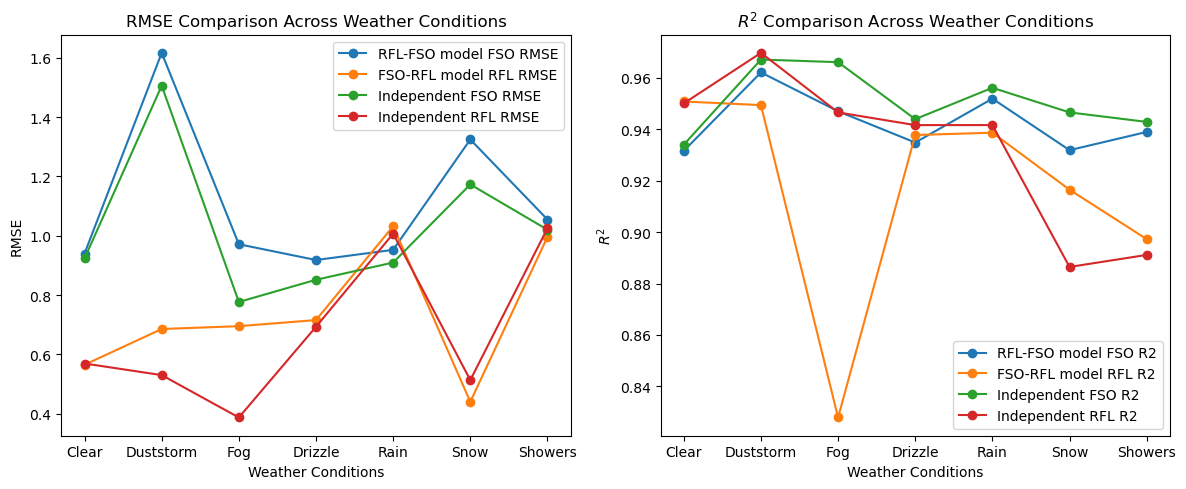

In [49]:
# Mapping of SYNOPCode to weather conditions
synop_to_weather = {
    0: "Clear",
    3: "Duststorm",
    4: "Fog",
    5: "Drizzle",
    6: "Rain",
    7: "Snow",
    8: "Showers"
}

# Define the order of SYNOP codes and corresponding weather conditions
ordered_synop_codes = [0, 3, 4, 5, 6, 7, 8]
weather_conditions = [synop_to_weather[code] for code in ordered_synop_codes]

# Sort the DataFrame by SYNOPCode
metrics_df_sorted = metrics_df.sort_values(by='SYNOPCode')

# Create a new column in the DataFrame to map SYNOPCode to weather conditions
metrics_df_sorted['Weather'] = metrics_df_sorted['SYNOPCode'].map(synop_to_weather)
print(metrics_df_sorted)
# Plotting
plt.figure(figsize=(12,5))

# Plot RMSE
plt.subplot(1, 2, 1)
plt.plot(weather_conditions, metrics_df_sorted['RFL-FSO_RMSE'], label='RFL-FSO model FSO RMSE', marker='o')
plt.plot(weather_conditions, metrics_df_sorted['FSO-RFL_RMSE'], label='FSO-RFL model RFL RMSE', marker='o')
plt.plot(weather_conditions, metrics_df_sorted['Independent_FSO_RMSE'], label='Independent FSO RMSE', marker='o')
plt.plot(weather_conditions, metrics_df_sorted['Independent_RFL_RMSE'], label='Independent RFL RMSE', marker='o')
plt.xlabel('Weather Conditions')
plt.ylabel('RMSE')
plt.title('RMSE Comparison Across Weather Conditions')
plt.legend()

# Plot R2
plt.subplot(1, 2, 2)
plt.plot(weather_conditions, metrics_df_sorted['RFL-FSO_R2'], label='RFL-FSO model FSO R2', marker='o')
plt.plot(weather_conditions, metrics_df_sorted['FSO-RFL_R2'], label='FSO-RFL model RFL R2', marker='o')
plt.plot(weather_conditions, metrics_df_sorted['Independent_FSO_R2'], label='Independent FSO R2', marker='o')
plt.plot(weather_conditions, metrics_df_sorted['Independent_RFL_R2'], label='Independent RFL R2', marker='o')
plt.xlabel('Weather Conditions')
plt.ylabel('$R^2$')
plt.title('$R^2$ Comparison Across Weather Conditions')
plt.legend()

plt.tight_layout()
plt.show()


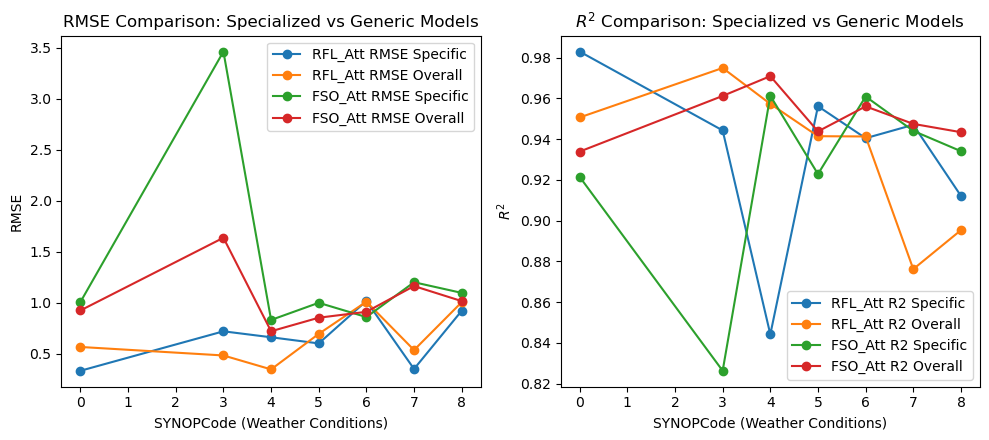

In [50]:
# Data preparation
data = {
    'SYNOPCode': [0, 3, 4, 5, 6, 7, 8],
    'RFL_Att_RMSE_Specific': [0.333067285209254, 0.7198794675539985, 0.6615122693228087, 0.601155262632656, 
                              1.017613271887995, 0.3507719267008508, 0.9212540214827],
    'RFL_Att_RMSE_Overall': [0.5663739747231987, 0.48310010764765104, 0.3464706309564142, 0.6946292744383606, 
                             1.0102857379803853, 0.5360986720851445, 1.0055979324593343],
    'RFL_Att_R2_Specific': [0.9829227480206155, 0.9442353566755969, 0.8441832558707966, 0.9561147033023485, 
                            0.940424722950265, 0.9469936419980651, 0.9121313221894752],
    'RFL_Att_R2_Overall': [0.9506189170187457, 0.9748861310459226, 0.9572563926225823, 0.9414061686575174, 
                           0.9412796020621388, 0.8761865651745346, 0.8953054579291132],
    'FSO_Att_RMSE_Specific': [1.0077486319697493, 3.462283758234632, 0.8312160420239142, 0.9994033373088915, 
                              0.8594275639074546, 1.200956388259691, 1.0965553598935949],
    'FSO_Att_RMSE_Overall': [0.9244832465947075, 1.6371287182597296, 0.7203960259017286, 0.8531754403321858, 
                             0.9109756150247456, 1.1635367317303968, 1.0161234650401005],
    'FSO_Att_R2_Specific': [0.9214217738020292, 0.8263158399453414, 0.9612212886525133, 0.9228324804602798, 
                            0.9608736640282285, 0.9440159799382478, 0.9340530669589923],
    'FSO_Att_R2_Overall': [0.933870402851375, 0.9611670351553379, 0.9708721682650524, 0.943762029391648, 
                           0.9560393478156558, 0.9474503529209222, 0.9433726237332157]
}

df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10,4.5))

# RMSE plot
plt.subplot(1, 2, 1)
plt.plot(df['SYNOPCode'], df['RFL_Att_RMSE_Specific'], label='RFL_Att RMSE Specific', marker='o')
plt.plot(df['SYNOPCode'], df['RFL_Att_RMSE_Overall'], label='RFL_Att RMSE Overall', marker='o')
plt.plot(df['SYNOPCode'], df['FSO_Att_RMSE_Specific'], label='FSO_Att RMSE Specific', marker='o')
plt.plot(df['SYNOPCode'], df['FSO_Att_RMSE_Overall'], label='FSO_Att RMSE Overall', marker='o')
plt.xlabel('SYNOPCode (Weather Conditions)')
plt.ylabel('RMSE')
plt.title('RMSE Comparison: Specialized vs Generic Models')
plt.legend()

# R2 plot
plt.subplot(1, 2, 2)
plt.plot(df['SYNOPCode'], df['RFL_Att_R2_Specific'], label='RFL_Att R2 Specific', marker='o')
plt.plot(df['SYNOPCode'], df['RFL_Att_R2_Overall'], label='RFL_Att R2 Overall', marker='o')
plt.plot(df['SYNOPCode'], df['FSO_Att_R2_Specific'], label='FSO_Att R2 Specific', marker='o')
plt.plot(df['SYNOPCode'], df['FSO_Att_R2_Overall'], label='FSO_Att R2 Overall', marker='o')
plt.xlabel('SYNOPCode (Weather Conditions)')
plt.ylabel('$R^2$')
plt.title('$R^2$ Comparison: Specialized vs Generic Models')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#read csv
df = pd.read_csv("RFLFSODataFull.csv")

Index(['FSO_Att', 'RFL_Att', 'AbsoluteHumidity', 'AbsoluteHumidityMax',
       'AbsoluteHumidityMin', 'Distance', 'Frequency', 'Particulate',
       'ParticulateMax', 'ParticulateMin', 'RainIntensity', 'RainIntensityMax',
       'RainIntensityMin', 'RelativeHumidity', 'SYNOPCode', 'Temperature',
       'TemperatureDifference', 'TemperatureMax', 'TemperatureMin', 'Time',
       'Visibility', 'VisibilityMax', 'VisibilityMin', 'WindDirection',
       'WindSpeed', 'WindSpeedMax', 'WindSpeedMin'],
      dtype='object')


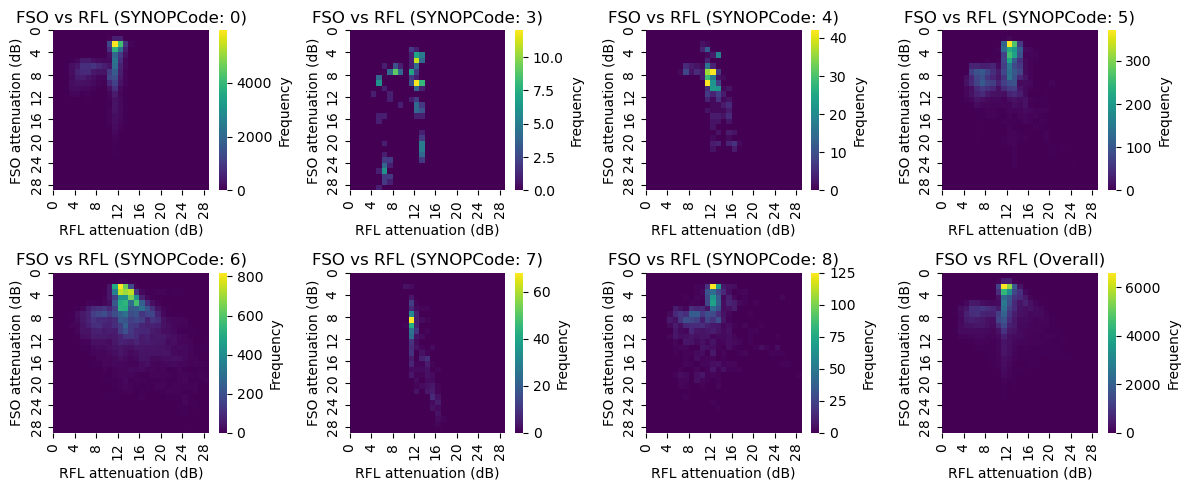

In [71]:
# Bin size and ranges
bin_size = 1
bins_fso = np.arange(0, 30, bin_size)
bins_rfl = np.arange(0, 30, bin_size)

# Helper function to set tick labels with a step size
def set_tick_labels(ax, x, y, step=4):
    ax.set_xticks(np.arange(0, len(x[:-1]), step))
    ax.set_yticks(np.arange(0, len(y[:-1]), step))
    ax.set_xticklabels(np.round(x[:-1:step], 1))
    ax.set_yticklabels(np.round(y[:-1:step], 1))


fig, axes = plt.subplots(2, 4, figsize=(12,5), sharex=False, sharey=False)

# SYNOPCode-specific heatmaps
codes = [0, 3, 4, 5, 6, 7, 8]
for i, code in enumerate(codes):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    subset = df[df['SYNOPCode'] == code]
    h_data, x, y = np.histogram2d(subset['RFL_Att'], subset['FSO_Att'], bins=[bins_rfl, bins_fso])
    
    sns.heatmap(h_data.T, cmap='viridis', cbar_kws={'label': 'Frequency'}, ax=ax)
    set_tick_labels(ax, x, y, step=4)
    ax.set_title(f'FSO vs RFL (SYNOPCode: {code})')
    ax.set_xlabel('RFL attenuation (dB)')
    ax.set_ylabel('FSO attenuation (dB)')

# Overall heatmap 
ax = axes[1, 3]
subset = df
h_data, x, y = np.histogram2d(subset['RFL_Att'], subset['FSO_Att'], bins=[bins_rfl, bins_fso])

sns.heatmap(h_data.T, cmap='viridis', cbar_kws={'label': 'Frequency'}, ax=ax)
set_tick_labels(ax, x, y, step=4)
ax.set_title('FSO vs RFL (Overall)')
ax.set_xlabel('RFL attenuation (dB)')
ax.set_ylabel('FSO attenuation (dB)')

plt.tight_layout()
plt.show()

